In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
from abc import ABC, abstractmethod
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

# Create DataSet Classes

# Data Processing Pipeline

This code defines an abstract base class structure for a data processing pipeline. The pipeline consists of three main steps: loading data, normalizing data, and encoding data. Each step is represented by an abstract base class (ABC) with an abstract method that must be implemented by any concrete subclass.

## Classes

### `LoadDataSet`
- **Description**: Abstract base class for loading data.
- **Methods**:
  - `load_data(self)`: Abstract method that must be implemented by subclasses to define how data is loaded.

### `NormalizeDataSet`
- **Description**: Abstract base class for normalizing data.
- **Methods**:
  - `normalize_data(self)`: Abstract method that must be implemented by subclasses to define how data is normalized.

### `EncodeDataSet`
- **Description**: Abstract base class for encoding data.
- **Methods**:
  - `encode_data(self)`: Abstract method that must be implemented by subclasses to define how data is encoded.

In [2]:
class LoadDataSet(ABC):
    @abstractmethod
    def load_data(self):
        pass
    
class NormalizeDataSet(ABC):
    @abstractmethod
    def normalize_data(self):
        pass
    
class EncodeDataSet(ABC):
    @abstractmethod
    def encode_data(self):
        pass
    
    

# CIFAR-10 Data Processing Pipeline

This code implements a data processing pipeline for the CIFAR-10 dataset using the abstract base classes defined earlier. The pipeline consists of three steps: loading the dataset, normalizing the pixel values, and one-hot encoding the labels.

## Classes

### `CifarTenLoader`
- **Description**: Concrete implementation of `LoadDataSet` for loading the CIFAR-10 dataset.
- **Methods**:
  - `load_data(self)`: Loads the CIFAR-10 dataset using Keras's `cifar10.load_data()` function.
  - **Returns**: A tuple containing the training and testing data (images and labels).

### `CifarTenNormalize`
- **Description**: Concrete implementation of `NormalizeDataSet` for normalizing CIFAR-10 image data.
- **Methods**:
  - `normalize_data(self, data: np.ndarray)`: Normalizes the pixel values of the images to the range `[0, 1]`.
    - Reshapes the data to the format `(num_samples, 32, 32, 3)`.
    - Converts the pixel values to `float32` and divides by `255` to normalize.
  - **Returns**: Normalized image data.

### `CifarTenEncode`
- **Description**: Concrete implementation of `EncodeDataSet` for one-hot encoding CIFAR-10 labels.
- **Methods**:
  - `encode_data(self, labels)`: Converts integer labels into one-hot encoded vectors using Keras's `to_categorical` function.
  - **Returns**: One-hot encoded labels.

In [3]:
# Load the CIFAR-10 dataset using Keras
class CifarTenLoader(LoadDataSet):
    def load_data(self):
        return cifar10.load_data()

# Normalize the pixel values to the range [0, 1].
class CifarTenNormalize(NormalizeDataSet):
    def normalize_data(self,data:np.ndarray):
        return data.reshape((data.shape[0], 32, 32, 3)).astype('float32') / 255

# One-hot encode the labels. 
class CifarTenEncode(EncodeDataSet):
    def encode_data(self,labels):
        return to_categorical(labels)

# CIFAR-10 Dataset Loader and Preprocessor

The `CifarTenDataset` class is a utility class designed to load and preprocess the CIFAR-10 dataset in a modular and reusable way. It uses dependency injection to accept instances of `LoadDataSet`, `NormalizeDataSet`, and `EncodeDataSet` for loading, normalizing, and encoding the dataset, respectively.

## Class: `CifarTenDataset`

### Description
This class encapsulates the entire process of loading and preprocessing the CIFAR-10 dataset. It leverages the provided data loader, normalizer, and encoder to perform the necessary steps.

### Attributes
- `data_loader`: An instance of `LoadDataSet` for loading the dataset.
- `data_normalize`: An instance of `NormalizeDataSet` for normalizing the dataset.
- `data_encode`: An instance of `EncodeDataSet` for encoding the labels.
- `train_images`: Stores the normalized training images.
- `test_images`: Stores the normalized testing images.
- `train_labels`: Stores the one-hot encoded training labels.
- `test_labels`: Stores the one-hot encoded testing labels.

### Methods
- `__init__(self, data_loader: LoadDataSet, data_normalize: NormalizeDataSet, data_encode: EncodeDataSet)`:
  - Initializes the class with instances of `LoadDataSet`, `NormalizeDataSet`, and `EncodeDataSet`.
  - Sets `train_images`, `test_images`, `train_labels`, and `test_labels` to `None` initially.

- `load_and_preprocess_data(self)`:
  - Loads the CIFAR-10 dataset using the provided `data_loader`.
  - Normalizes the training and testing images using the provided `data_normalize`.
  - Encodes the training and testing labels using the provided `data_encode`.
  - Returns the preprocessed data as a tuple: `(train_images, train_labels, test_images, test_labels)`.

In [4]:
# Load and Preprocess the Data 
class CifarTenDataset:
    def __init__(self,data_loader:LoadDataSet,data_normalize:NormalizeDataSet,data_encode:EncodeDataSet):
        self.data_loader = data_loader
        self.data_normalize = data_normalize
        self.data_encode = data_encode
        self.train_images = None
        self.test_images = None
        self.train_labels = None
        self.test_labels = None
        
    def load_and_preprocess_data(self):
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = self.data_loader.load_data()
        self.train_images=self.data_normalize.normalize_data(self.train_images)
        self.test_images=self.data_normalize.normalize_data(self.test_images)
        self.train_labels=self.data_encode.encode_data(self.train_labels)
        self.test_labels=self.data_encode.encode_data(self.test_labels)
        return self.train_images, self.train_labels, self.test_images, self.test_labels

### Load and Preprocess the Data

In [5]:
data_loader=CifarTenLoader()
normalize_data=CifarTenNormalize()
encode_data=CifarTenEncode()

In [6]:
preprocess_data=CifarTenDataset(data_loader,normalize_data,encode_data)
train_images, train_labels, test_images, test_labels=preprocess_data.load_and_preprocess_data()

### Visualization The Data

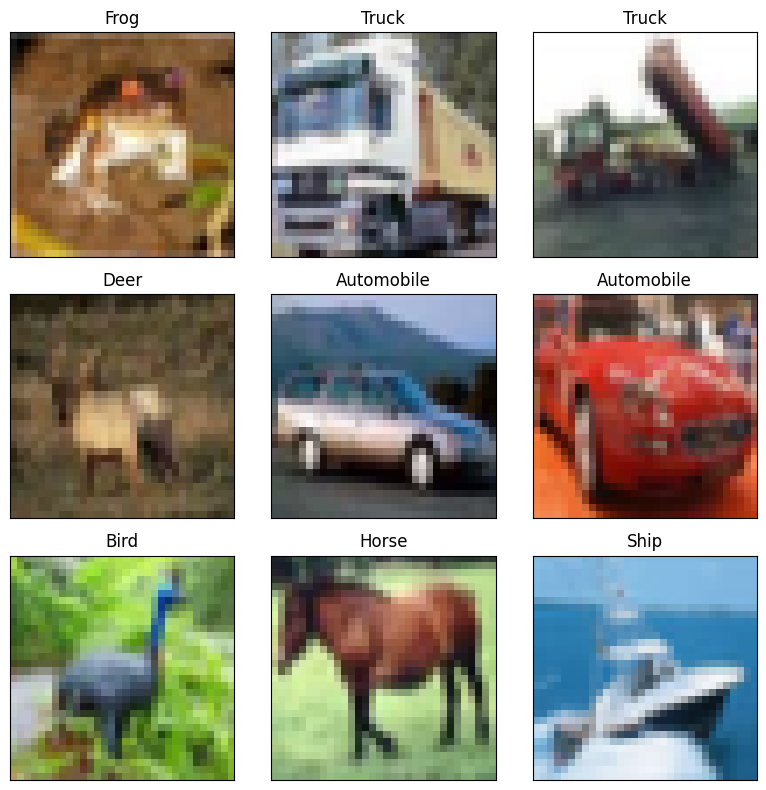

In [7]:
(images, labels), _ = data_loader.load_data()
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through images and plot
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])  # No cmap needed for RGB images
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[int(labels[i][0])])  # Fix label placement

# Adjust layout to fix spacing issues
plt.tight_layout()
plt.show()

# Create Model Classes

# Model Pipeline Abstraction

This code defines an abstract base class structure for a machine learning model pipeline. The pipeline consists of three main steps: building a model, training the model, and evaluating the model. Each step is represented by an abstract base class (ABC) with an abstract method that must be implemented by any concrete subclass.

## Classes

### `BuildModel`
- **Description**: Abstract base class for building a machine learning model.
- **Methods**:
  - `build_model(self)`: Abstract method that must be implemented by subclasses to define how the model is constructed.
  - **Returns**: A compiled or initialized model.

### `TrainModel`
- **Description**: Abstract base class for training a machine learning model.
- **Methods**:
  - `train_model(self, model)`: Abstract method that must be implemented by subclasses to define how the model is trained.
    - `model`: The model to be trained.
  - **Returns**: The trained model (optional, depending on implementation).

### `EvaluateModel`
- **Description**: Abstract base class for evaluating a machine learning model.
- **Methods**:
  - `evaluate_model(self, model)`: Abstract method that must be implemented by subclasses to define how the model is evaluated.
    - `model`: The model to be evaluated.
  - **Returns**: Evaluation metrics (e.g., accuracy, loss, etc.).

In [8]:
class BuildModel(ABC):
    @abstractmethod
    def build_model(self):
        pass

class TrainModel(ABC):
    @abstractmethod
    def train_model(self,model):
        pass

class EvaluateModel(ABC):
    @abstractmethod
    def evaluate_model(self,model):
        pass

# Configuration Classes for Model Pipeline

This code defines three configuration classes using Python's `dataclass` decorator. These classes are used to encapsulate the configuration parameters required for building, training, and evaluating a machine learning model. Using `dataclass` simplifies the creation of these classes by automatically generating boilerplate code like `__init__`, `__repr__`, and `__eq__`.

## Classes

### `BuilderConfiguration`
- **Description**: Encapsulates the configuration for building a model.
- **Attributes**:
  - `layers`: A list of Keras `Layer` objects defining the architecture of the model.
  - `optimizer`: A string specifying the optimizer to use (e.g., `"adam"`, `"sgd"`).
  - `loss`: A string specifying the loss function to use (e.g., `"categorical_crossentropy"`).
  - `metrics`: A list of strings specifying the metrics to track during training and evaluation (e.g., `["accuracy"]`).

### `TrainConfiguration`
- **Description**: Encapsulates the configuration for training a model.
- **Attributes**:
  - `train_data`: A NumPy array containing the training data.
  - `train_labels`: A NumPy array containing the training labels.
  - `epochs`: An integer specifying the number of epochs to train the model.
  - `batch_size`: An integer specifying the batch size for training.
  - `validation_split`: A float specifying the fraction of the training data to use for validation.
  - `callbacks`: A list of Keras `Callback` objects for customizing the training process (e.g., early stopping, learning rate scheduling).

### `EvaluationConfiguration`
- **Description**: Encapsulates the configuration for evaluating a model.
- **Attributes**:
  - `test_data`: A NumPy array containing the test data.
  - `test_labels`: A NumPy array containing the test labels.

In [9]:
from dataclasses import dataclass

@dataclass
class BuilderConfiguration:
    layers:list[layers.Layer]
    optimizer:str
    loss:str
    metrics:list[str]

@dataclass
class TrainConfiguration:
    train_data:np.ndarray
    train_labels:np.ndarray
    epochs:int
    batch_size:int
    validation_split:float
    callbacks:list[Callback]
    
@dataclass
class EvaluationConfiguration:
    test_data:np.ndarray
    test_labels:np.ndarray
    

# Convolutional Neural Network (CNN) Pipeline Implementation

This code implements the `BuildModel`, `TrainModel`, and `EvaluateModel` abstract base classes for a Convolutional Neural Network (CNN) pipeline. Each class is responsible for a specific part of the pipeline: building the model, training the model, and evaluating the model. These classes use the configuration dataclasses (`BuilderConfiguration`, `TrainConfiguration`, and `EvaluationConfiguration`) to encapsulate the required parameters.

## Classes

### `CNNBuilder`
- **Description**: Implements the `BuildModel` abstract base class for building a CNN model.
- **Attributes**:
  - `configuration`: An instance of `BuilderConfiguration` containing the model architecture and compilation parameters.
- **Methods**:
  - `build_model(self)`:
    - Constructs a Sequential model using the layers specified in `self.configuration.layers`.
    - Compiles the model using the optimizer, loss function, and metrics specified in `self.configuration`.
    - **Returns**: A compiled Keras model.

### `CNNTrain`
- **Description**: Implements the `TrainModel` abstract base class for training a CNN model.
- **Attributes**:
  - `configuration`: An instance of `TrainConfiguration` containing the training data and parameters.
- **Methods**:
  - `train_model(self, model)`:
    - Trains the model using the training data and parameters specified in `self.configuration`.
    - **Returns**: A Keras `History` object containing training and validation metrics.

### `CNNEvaluate`
- **Description**: Implements the `EvaluateModel` abstract base class for evaluating a CNN model.
- **Attributes**:
  - `configuration`: An instance of `EvaluationConfiguration` containing the test data and labels.
- **Methods**:
  - `evaluate_model(self, model)`:
    - Evaluates the model on the test data specified in `self.configuration`.
    - **Returns**: A tuple containing the test loss and test accuracy.

In [10]:
class CNNBuilder(BuildModel):
    def __init__(self,configuration:BuilderConfiguration):
        self.configuration = configuration
    
    def build_model(self):
        model = models.Sequential(self.configuration.layers)
        model.compile(optimizer=self.configuration.optimizer,
                      loss=self.configuration.loss,metrics=self.configuration.metrics)
        
        return model

class CNNTrain(TrainModel):
    def __init__(self,configuration:TrainConfiguration):
        self.configuration = configuration
    
    def train_model(self,model):
        history = model.fit(self.configuration.train_data,self.configuration.train_labels
                                               ,epochs=self.configuration.epochs,batch_size=self.configuration.batch_size
                                               ,validation_split=self.configuration.validation_split
                                               ,callbacks=self.configuration.callbacks)
        return history

class CNNEvaluate(EvaluateModel):
    def __init__(self,configuration:EvaluationConfiguration):
        self.configuration = configuration
    
    def evaluate_model(self,model):
        test_loss, test_acc=model.evaluate(self.configuration.test_data,self.configuration.test_labels)
        return test_loss, test_acc

# CNN Pipeline Orchestrator

The `CNNPipeline` class is an orchestrator that ties together the building, training, and evaluation of a Convolutional Neural Network (CNN) model. It uses instances of `CNNBuilder`, `CNNTrain`, and `CNNEvaluate` to perform the respective tasks in a sequential manner. This class ensures that the pipeline is executed correctly and provides a clean interface for running the entire workflow.

## Class: `CNNPipeline`

### Description
This class encapsulates the entire process of building, training, and evaluating a CNN model. It validates the configurations provided for each step and ensures that the pipeline is executed in the correct order.

### Attributes
- `builder`: An instance of `CNNBuilder` for building the model.
- `train`: An instance of `CNNTrain` for training the model.
- `evaluate`: An instance of `CNNEvaluate` for evaluating the model.
- `model`: Stores the built and trained model.
- `history`: Stores the training history (e.g., loss and accuracy over epochs).
- `test_loss`: Stores the loss computed during model evaluation.
- `test_acc`: Stores the accuracy computed during model evaluation.

### Methods
- `__init__(self, builder: CNNBuilder, train: CNNTrain, evaluate: CNNEvaluate)`:
  - Initializes the pipeline with instances of `CNNBuilder`, `CNNTrain`, and `CNNEvaluate`.
  - Sets `model`, `history`, `test_loss`, and `test_acc` to `None` initially.

- `pipeline(self)`:
  - Validates that the configurations for building, training, and evaluation are not empty.
  - Builds the model using `CNNBuilder`.
  - Trains the model using `CNNTrain`.
  - Evaluates the model using `CNNEvaluate`.
  - Returns a tuple containing the trained model, training history, test loss, and test accuracy.

In [11]:
class CNNPipeline:
    def __init__(self,builder:CNNBuilder,train:CNNTrain,evaluate:CNNEvaluate):
        self.builder = builder
        self.train = train
        self.evaluate = evaluate
        self.model = None
        self.history = None
        self.test_loss = None
        self.test_acc = None
    
    def pipeline(self):
        if not self.builder.configuration:
            raise ValueError('Model configuration cannot be empty')
        if not self.train.configuration:
            raise ValueError('Training configuration cannot be empty')
        if not self.evaluate.configuration:
            raise ValueError('Evaluation configuration cannot be empty')
        
        self.model = self.builder.build_model()
        self.history = self.train.train_model(model=self.model)
        self.test_loss,self.test_acc = self.evaluate.evaluate_model(model=self.model)
        return self.model, self.history, self.test_loss, self.test_acc

# Create plot classes

# Visualization Abstract Base Class

The `Visualization` class is an abstract base class (ABC) that defines a blueprint for creating visualization components in a machine learning pipeline. It ensures that any concrete implementation of a visualization class must implement the `visualize` method, which is responsible for generating and displaying visualizations (e.g., plots, graphs, or charts).

## Class: `Visualization`

### Description
This abstract base class serves as a contract for creating visualization components. It is part of a modular design pattern, allowing different types of visualizations to be implemented and integrated into the pipeline without modifying the core logic.

### Methods
- `visualize(self)`: 
  - Abstract method that must be implemented by subclasses.
  - Responsible for generating and displaying visualizations based on the data or model provided.
  - **Returns**: None (typically, this method will display plots or save visualizations to files).

In [12]:
class Visualization(ABC):
    @abstractmethod
    def visualize(self):
        pass


# Visualization Implementations for Training and Validation Metrics

The `TrainValidationAccuracy` and `TrainValidationLoss` classes are concrete implementations of the `Visualization` abstract base class. They are designed to visualize the training and validation accuracy and loss over epochs, respectively. These classes use Matplotlib to generate plots, providing insights into the model's performance during training.

## Classes

### `TrainValidationAccuracy`
- **Description**: Visualizes the training and validation accuracy over epochs.
- **Attributes**:
  - `history`: A Keras `History` object containing the training and validation metrics.
- **Methods**:
  - `visualize(self)`:
    - Plots the training accuracy and validation accuracy over epochs.
    - Adds labels, a legend, and displays the plot using Matplotlib.

### `TrainValidationLoss`
- **Description**: Visualizes the training and validation loss over epochs.
- **Attributes**:
  - `history`: A Keras `History` object containing the training and validation metrics.
- **Methods**:
  - `visualize(self)`:
    - Plots the training loss and validation loss over epochs.
    - Adds labels, a legend, and displays the plot using Matplotlib.

In [13]:
class TrainValidationAccuracy(Visualization):
    def __init__(self,history):
        self.history = history

    def visualize(self):
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

class TrainValidationLoss(Visualization):
    def __init__(self,history):
        self.history = history
    
    def visualize(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Learning Rate Scheduler and Early Stopping Callbacks

This code defines a learning rate scheduler function and creates Keras callbacks for learning rate scheduling and early stopping. These callbacks are commonly used during model training to improve performance and prevent overfitting.

## Components

### `learning_rate_scheduler` Function
- **Description**: A custom function to adjust the learning rate during training based on the current epoch.
- **Parameters**:
  - `epoch`: The current epoch number during training.
- **Logic**:
  - The initial learning rate is set to `0.001`.
  - The learning rate decays by a factor of `0.1` every `5` epochs.
  - The updated learning rate is calculated as:
    ```python
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    ```
- **Returns**: The updated learning rate for the current epoch.

### `LearningRateScheduler` Callback
- **Description**: A Keras callback that uses the `learning_rate_scheduler` function to adjust the learning rate dynamically during training.
- **Usage**:
  ```python
  lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

In [14]:
def learning_rate_scheduler(epoch):
    initial_lr=0.001
    decay_factor=0.1
    decay_epochs=5
    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return lr

lr_scheduler=LearningRateScheduler(learning_rate_scheduler)
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Build a CNN Model

In [15]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

C:\Users\GIGABYTE\Desktop\CAP\Advanced Machine Learning Topics\Assignments\Assignment-2 cnn\CNN Image Classification CIFAR10\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3703 - loss: 1.7244 - val_accuracy: 0.5564 - val_loss: 1.2628 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5798 - loss: 1.1845 - val_accuracy: 0.6160 - val_loss: 1.0896 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6397 - loss: 1.0313 - val_accuracy: 0.6387 - val_loss: 1.0216 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6744 - loss: 0.9260 - val_accuracy: 0.6649 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7051 - loss: 0.8467 - val_accuracy: 0.6839 - val_loss: 0.9462 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7522 - loss: 0.7238 - val_accuracy: 0.7016 - val_loss: 0.8892 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.765

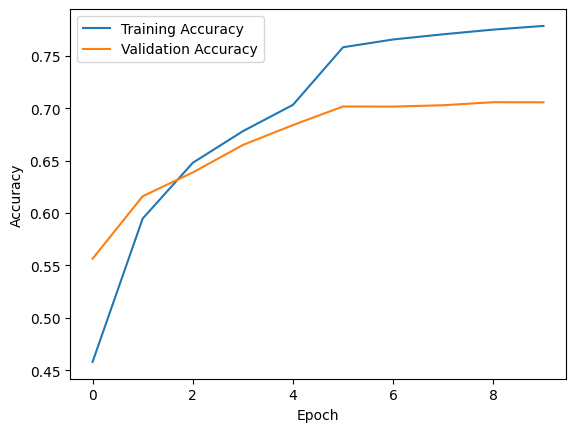

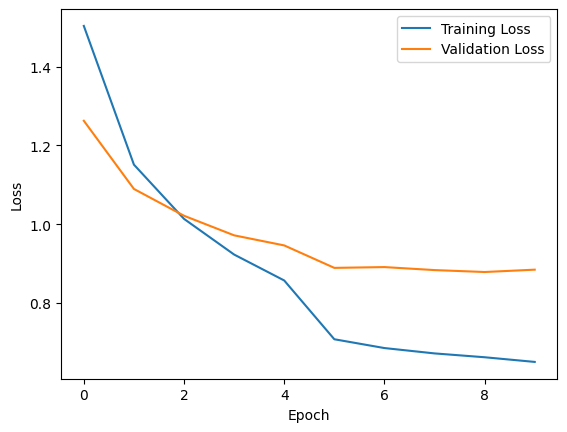

In [17]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Add dropout layers to reduce overfitting.

In [18]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=20,batch_size=16,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [19]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.3130 - loss: 1.8468 - val_accuracy: 0.5063 - val_loss: 1.4067 - learning_rate: 0.0010
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4943 - loss: 1.4015 - val_accuracy: 0.5692 - val_loss: 1.2585 - learning_rate: 0.0010
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5439 - loss: 1.2721 - val_accuracy: 0.5963 - val_loss: 1.1795 - learning_rate: 0.0010
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5715 - loss: 1.2052 - val_accuracy: 0.5992 - val_loss: 1.1744 - learning_rate: 0.0010
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5889 - loss: 1.1617 - val_accuracy: 0.5930 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6241 - loss: 1.0585 - val_accuracy: 0.6575 - val_loss: 1.0148 - learning_rate: 1.0000e-04
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy:

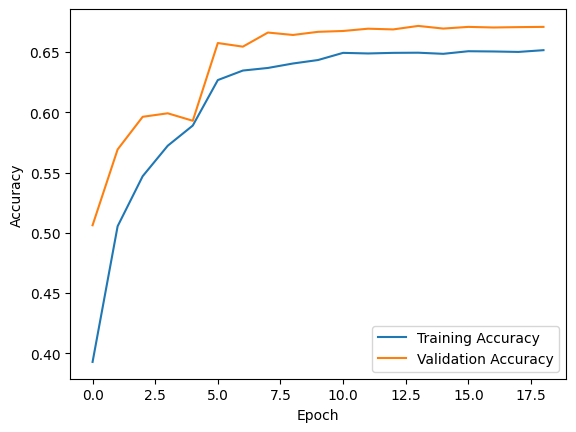

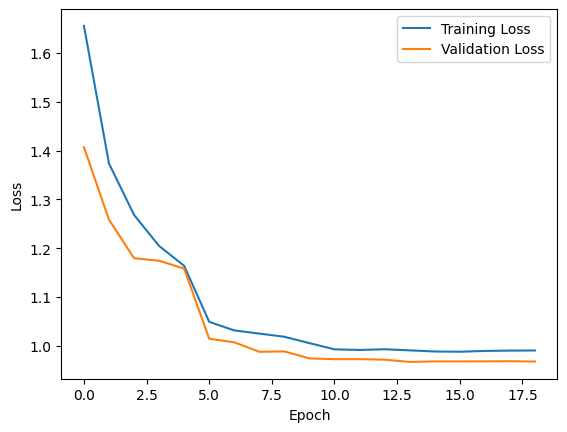

In [20]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Increase the depth (number of conv layers) or width (number of filters) of the model. 

In [21]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [22]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3198 - loss: 1.8257 - val_accuracy: 0.5002 - val_loss: 1.4178 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5466 - loss: 1.2661 - val_accuracy: 0.5958 - val_loss: 1.1501 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6219 - loss: 1.0820 - val_accuracy: 0.6339 - val_loss: 1.0640 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6601 - loss: 0.9703 - val_accuracy: 0.6576 - val_loss: 0.9862 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6895 - loss: 0.8924 - val_accuracy: 0.6682 - val_loss: 0.9700 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7452 - loss: 0.7459 - val_accuracy: 0.7022 - val_loss: 0.8771 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.759

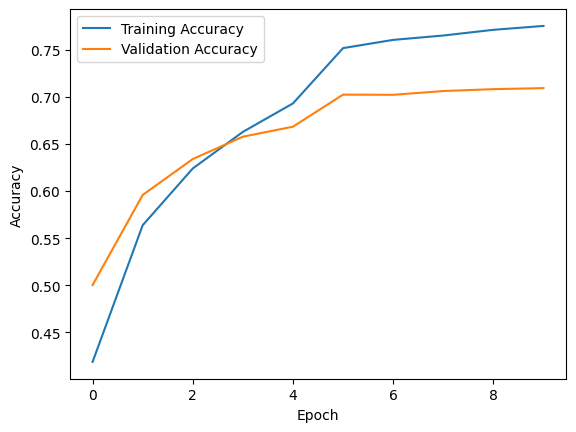

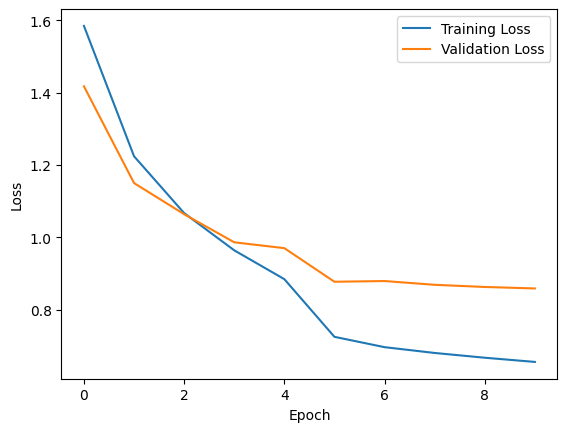

In [23]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Use data augmentation to increase the diversity of the training data.

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

build_config = BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']
)

aug_train, val_train, aug_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

builder = CNNBuilder(build_config)
model = builder.build_model()

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(aug_train, aug_labels, batch_size=32)
val_generator = val_datagen.flow(val_train, val_labels, batch_size=32)

history = model.fit(
    train_generator,
    steps_per_epoch=len(aug_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_train) // 32,
    verbose=5,
    callbacks=[lr_scheduler,early_stopping]
)

evaluate_config = EvaluationConfiguration(test_data=test_images, test_labels=test_labels)
evaluate = CNNEvaluate(evaluate_config)
test_loss, test_acc = evaluate.evaluate_model(model)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7319 - loss: 0.7784
Test loss: 0.783531904220581
Test accuracy: 0.7257999777793884


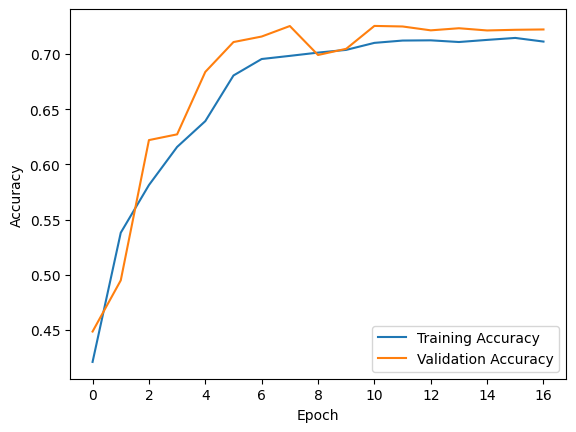

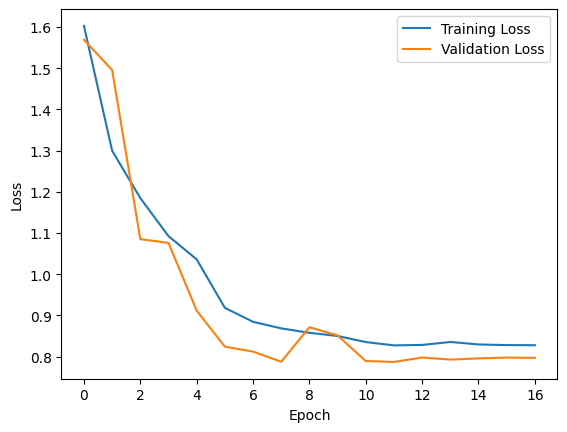

In [28]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

build_config = BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy']
)

aug_train, val_train, aug_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

builder = CNNBuilder(build_config)
model = builder.build_model()

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(aug_train, aug_labels, batch_size=32)
val_generator = val_datagen.flow(val_train, val_labels, batch_size=32)

history = model.fit(
    train_generator,
    steps_per_epoch=len(aug_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_train) // 32,
    verbose=5,
    callbacks=[lr_scheduler,early_stopping]
)

evaluate_config = EvaluationConfiguration(test_data=test_images, test_labels=test_labels)
evaluate = CNNEvaluate(evaluate_config)
test_loss, test_acc = evaluate.evaluate_model(model)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7359 - loss: 0.7784
Test loss: 0.7829234600067139
Test accuracy: 0.73580002784729


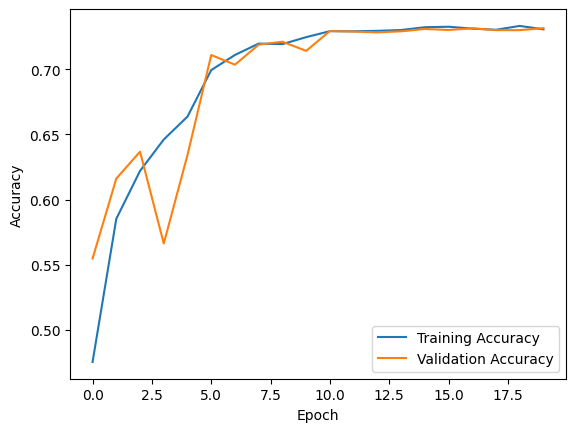

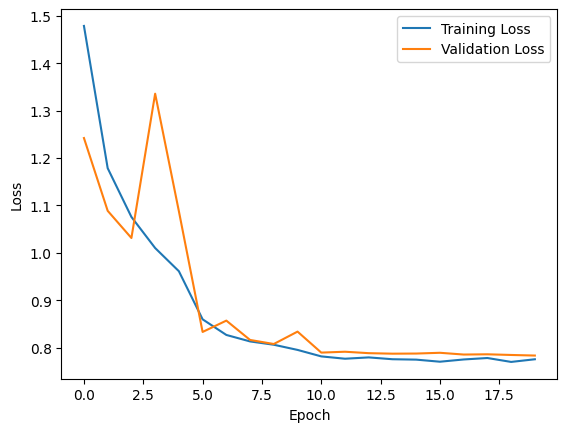

In [30]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Use adamw  optimizer

In [37]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
],
    optimizer="adamw",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [38]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3711 - loss: 1.7252 - val_accuracy: 0.5529 - val_loss: 1.2596 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5860 - loss: 1.1789 - val_accuracy: 0.6239 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6475 - loss: 1.0011 - val_accuracy: 0.6516 - val_loss: 0.9953 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6856 - loss: 0.8968 - val_accuracy: 0.6583 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7167 - loss: 0.8141 - val_accuracy: 0.6818 - val_loss: 0.9272 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7668 - loss: 0.6781 - val_accuracy: 0.7019 - val_loss: 0.8754 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.781

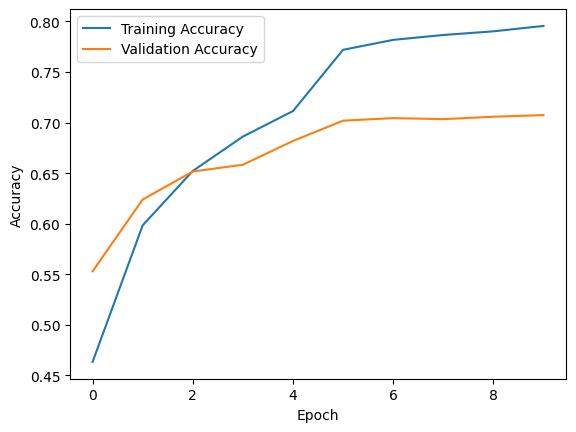

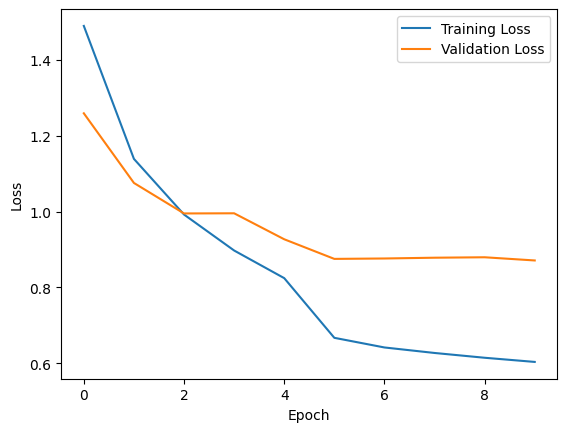

In [39]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()

### Add batch normalization layers to stabilize training. 

In [55]:
build_config=BuilderConfiguration(layers=[
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
],
    optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy']
)

train_config=TrainConfiguration(train_data=train_images,train_labels=train_labels,epochs=10,batch_size=32,
                                validation_split=0.2,callbacks=[lr_scheduler,early_stopping])

evaluate_config=EvaluationConfiguration(test_data=test_images,test_labels=test_labels)

In [56]:
builder=CNNBuilder(build_config)
train=CNNTrain(train_config)
evaluation=CNNEvaluate(evaluate_config)

pipeline=CNNPipeline(builder,train,evaluation)
model, history, test_loss, test_acc=pipeline.pipeline()
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.4244 - loss: 1.6310 - val_accuracy: 0.4807 - val_loss: 1.5540 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6307 - loss: 1.0482 - val_accuracy: 0.5846 - val_loss: 1.1709 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6873 - loss: 0.8895 - val_accuracy: 0.6513 - val_loss: 0.9766 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7266 - loss: 0.7795 - val_accuracy: 0.6594 - val_loss: 1.0011 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.7550 - loss: 0.7032 - val_accuracy: 0.6652 - val_loss: 0.9750 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8127 - loss: 0.5514 - val_accuracy: 0.7260 - val_loss: 0.8064 - learning_rate: 1.0000e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accu

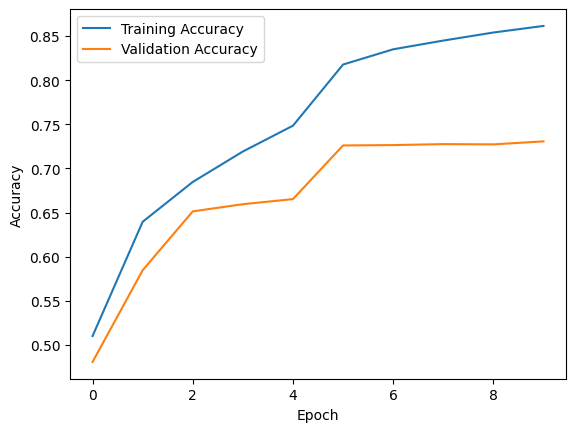

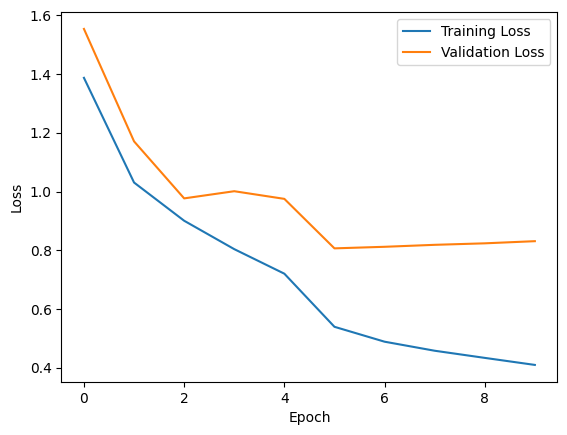

In [57]:
train_validation_accuracy=TrainValidationAccuracy(history)
train_validation_loss=TrainValidationLoss(history)
train_validation_accuracy.visualize()
train_validation_loss.visualize()